### Dataset - Sign Language MNIST
[Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

The dataset record the hand language gestures of alphabetic letter A-Z (except for J and Z), which is 24 classes in total. Each sample in the dataset is a $28\times 28$ gray-scale images, with their corresponding labels. The label is from 0-24 (except 9=j). And the total amount of samples is 34627, in which 27455 of them are for train set and 7172 of them are for tets set.

<img src='./data/amer_sign2.png'>

In [1]:
# import packages
from sklearn import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# load dataset
train_data_path = './data/sign_mnist_train.csv'
test_data_path = './data/sign_mnist_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_X = np.array(train_data[train_data.columns[1:]])
train_label = np.array(train_data['label'])

test_X = np.array(test_data[test_data.columns[1:]])
test_label = np.array(test_data['label'])

label_index = 'ABCDEFGHIKLMNOPQRSTUVWXY'
labels = np.unique(np.array(train_data['label']))
print(train_data.shape)
print(test_data.shape)
print(np.unique(np.array(train_data['label'])))


(27455, 785)
(7172, 785)
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


<img src='./data/amer_sign3.png'>

<BarContainer object of 24 artists>

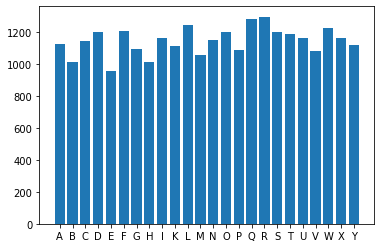

In [3]:
class_count = np.array(train_data.groupby('label').agg('count')['pixel1'])
x_axis = [idx for idx in label_index if idx not in 'JZ']
plt.bar(x_axis, class_count)

In [4]:
# sample list
samples = pd.DataFrame()
for i in labels:
    tmp = train_data.loc[train_data['label']==i].iloc[0]
    samples = pd.concat([samples, tmp], axis=1)

samples = np.array(samples.drop('label')).T
print(samples.shape)

(24, 784)


In [5]:
# def plot top 10 PC image
def plot_t10_pc(reducer):
    idx = 1
    plt.figure(figsize=(8, 4))
    for i in range(10):
        pc = reducer.components_[i].reshape(28, 28)
        plt.subplot(2, 5, idx)
        plt.gray()
        plt.title('PC' + str(i + 1))
        plt.imshow(pc)
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        idx += 1

def plot_recover_image(reduced_img):
    def plot_image(img, subidx):
        title = 'origin' if subidx == 1 else 'reducer'+str(subidx-1)

        plt.subplot(1, len(reduced_img) + 1, subidx)
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.title(title)
        plt.imshow(img.reshape(28,28))

    # plot origin image
    plt.figure(figsize=(8, 4))
    plot_image(train_X[0],1)

    # plot the image transformed by reducers in the list
    for i, img in enumerate(reduced_img):
        plot_image(img,i+2)

    return


In [6]:
# pre_processing 

# PCA dimension reduction
pca_reducer = decomposition.PCA(n_components=80)
train_X_pca = pca_reducer.fit_transform(train_X)
test_X_pca = pca_reducer.transform(test_X)


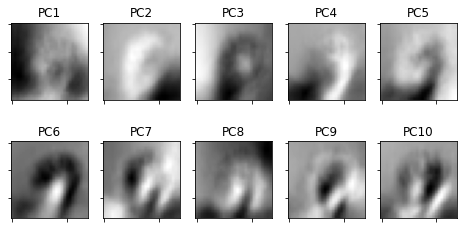

In [7]:
# top 10 PC of PCA
plot_t10_pc(pca_reducer)


In [8]:
# NMF dimension reduction
nmf_reducer = decomposition.NMF(n_components=80)
train_X_nmf = nmf_reducer.fit_transform(train_X)
test_X_nmf = nmf_reducer.fit(test_X)

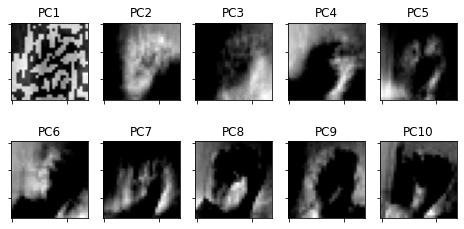

In [9]:
# top 10 component of NMF
plot_t10_pc(nmf_reducer)

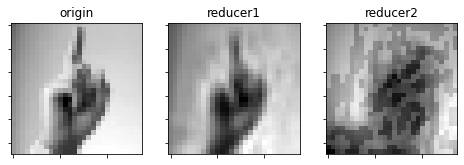

In [10]:
# comparison between original image and the reconstruction from dimension reduction
re_pca = pca_reducer.inverse_transform(train_X_pca)
re_nmf = nmf_reducer.inverse_transform(train_X_nmf)
plot_recover_image([re_pca[0], re_nmf[0]])

In [11]:
# kernel SVM

pca_model = svm.SVC(kernel='poly')
pca_model.fit(train_X_pca, train_label)

SVC(kernel='poly')

In [12]:
pred_label_test_pca = pca_model.predict(test_X_pca)
acc = metrics.accuracy_score(test_label, pred_label_test_pca)
print(acc)

0.8087005019520357


In [13]:
pred_label_train_pca = pca_model.predict(train_X_pca)
acc = metrics.accuracy_score(train_label, pred_label_train_pca)
print(acc)

0.9884174103077764


In [14]:
# kernel SVM
model = svm.SVC(kernel='poly')
model.fit(train_X, train_label)

SVC(kernel='poly')

In [15]:
pred_label_train = model.predict(train_X)
acc = metrics.accuracy_score(train_label, pred_label_train)
print(acc)

1.0


In [16]:
pred_label_test = model.predict(test_X)
acc = metrics.accuracy_score(test_label, pred_label_test)
print(acc)

0.782069157836029


In [23]:
class trainer():
    def __init__(self, reducer='PCA', model='kSVM'):
        self.reducer = reducer
        self.model = model

        self.comp_num = [4,8,10,20,40,50,80,100,150,200,300,500]

        self.train_X = train_X
        self.test_X = test_X

        self.train_acc = []
        self.test_acc = []

    def PCA_reducer(self, comp_num):
        pca_reducer = decomposition.PCA(n_components=comp_num)
        #self.train_X = pca_reducer.fit_transform(train_X)
        #self.test_X = pca_reducer.transform(test_X)
        return pca_reducer

    def NMF_reducer(self, comp_num):
        nmf_reducer = decomposition.NMF(n_components=comp_num)
        #self.train_X = nmf_reducer.fit_transform(train_X)
        #self.test_X = nmf_reducer.transform(test_X)
        return nmf_reducer

    def kernel_SVM(self):
        model = svm.SVC(kernel='poly')
        return model

    def train(self):
        models = []
        if self.model == 'kSVM':
            model = self.kernel_SVM()

        for idx, comp_num in enumerate(self.comp_num):
            print('train with {} components '.format(comp_num))
            if self.reducer == 'PCA':
                reducer = self.PCA_reducer(comp_num)
            elif self.reducer == 'NMF':
                reducer = self.NMF_reducer(comp_num)
            else:
                pass
            
            tmp_pipeline = pipeline.Pipeline([('reducer', reducer),('model', model)])
            grid_param = {'model__kernel':['poly','rbf'],
                          'model__C':np.logspace(-2,1,num=5)}
            
            tmp_model = model_selection.GridSearchCV(tmp_pipeline, grid_param, cv=5, n_jobs=12).fit(self.train_X, train_label)
            
            self.train_acc.append(metrics.accuracy_score(train_label, tmp_model.predict(self.train_X)))
            self.test_acc.append(metrics.accuracy_score(test_label, tmp_model.predict(self.test_X)))
            
            models.append(tmp_model)

        max_idx = self.test_acc.index(max(self.test_acc))
        print(self.comp_num[max_idx])
        return models[max_idx]

    def plot(self):
        plt.figure(figsize=(8,8))
        plt.plot(self.comp_num, self.train_acc, '-o', color='r', label='Train Accuracy')
        plt.plot(self.comp_num, self.test_acc, '-s', color='b', label='Test Accuracy')
        plt.title('Max accuracy {} with {} components'.format(max(self.test_acc), self.comp_num[self.test_acc.index(max(self.test_acc))]))
        plt.legend()


In [22]:
PCA_trainer = trainer('PCA')
PCA_model = PCA_trainer.train()
PCA_trainer.plot()
PCA_model.cv_results_

train with 4 components 
train with 8 components 
train with 10 components 
train with 20 components 
train with 40 components 


KeyboardInterrupt: 

train with 4 components 
train with 8 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 10 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 20 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 40 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 50 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 80 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 100 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 150 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 200 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 300 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


train with 500 components 


c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Really Monkey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


8


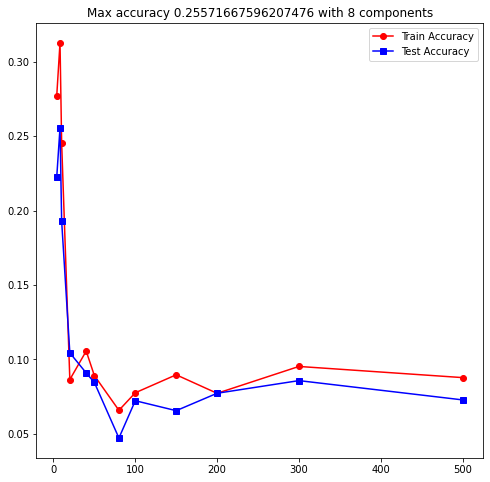

In [ ]:
NMF_trainer = trainer('NMF')
NMF_model = NMF_trainer.train()
NMF_trainer.plot()

In [ ]:
pred_label_test = PCA_model.predict(test_X)
metrics.accuracy_score(test_label, pred_label_test)

0.8759063022866704

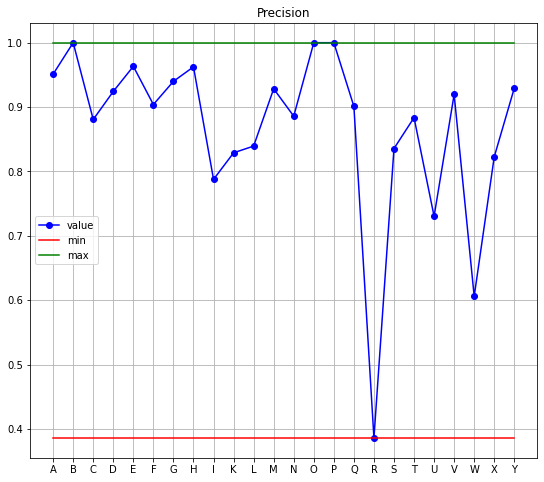

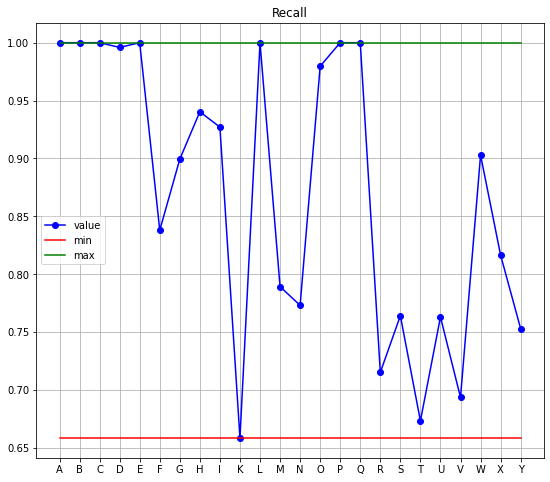

In [ ]:
label_df = pd.DataFrame({
    'True':test_label,
    'Pred':pred_label_test
})



# get True Positive for each label
def cal_TP_matrix(label_df):
    TP_matrix = np.zeros((24,24))

    for lb in labels:
        ture_count = label_df.loc[label_df['True'] == lb].groupby('Pred').agg(
            'count')
        for pred_idx, row in ture_count.iterrows():
            lb_idx = lb if lb < 9 else lb-1
            pred_idx = pred_idx if pred_idx < 9 else pred_idx-1
            TP_matrix[lb_idx][pred_idx] = row[0]

    return TP_matrix

def cal_TPR(label_df):
    RP = label_df.groupby('True').agg('count')
    PP = label_df.groupby('Pred').agg('count')
    TP = label_df.loc[label_df['True']==label_df['Pred']].groupby('True').agg('count')
    # print(RP,PP,TP)

    precision = np.array(TP).T[0] / np.array(PP).T[0]
    recall = np.array(TP).T[0] / np.array(RP).T[0]

    # plot Precision
    plot_data(precision, 'Precision', 121)
    plot_data(recall, 'Recall', 122)

    return precision, recall


def plot_data(data, title, pos):
    min_value = [min(data) for i in range(len(data))]
    max_value = [max(data) for i in range(len(data))]

    x_label = [i for i in label_index]

    plt.figure(figsize=(20, 8))
    fig = plt.subplot(pos)
    fig.plot(x_label, data, 'o-', color='b', label='value')
    fig.plot(x_label, min_value, '-', color='r', label='min')
    fig.plot(x_label, max_value, '-', color='g', label='max')
    fig.legend()
    fig.grid()
    fig.set_title(title)
    return


precision, recall = cal_TPR(label_df)


In [ ]:
pd.options.display.max_columns = None

label_index = [i for i in label_index]
TPmx = cal_TP_matrix(label_df)
pd.DataFrame(TPmx, label_index, label_index)


,A,B,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y
A,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,244.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
E,0.0,0.0,0.0,0.0,498.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,19.0,0.0,0.0,207.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,313.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,20.0,410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,218.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,30.0,2.0,17.0,0.0,0.0


Rows record the truth count.\
Columns record the predict count.

Take R as example which has the lowest precision and a relatively low recall.

In [24]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# select correct predicted sample
True_P = label_df.loc[(label_df['True'] == 17) & (label_df['True'] == label_df['Pred'])][:2]
# select the index of sample is true R been predicted to other classes
False_N = label_df.sort_values('Pred',ascending=True).loc[(label_df['True'] == 17) & (label_df['True'] != label_df['Pred'])].groupby('Pred').head(2)
# select the index of the sample been predicted to R but not R
False_P = label_df.sort_values('True',ascending=True).loc[(label_df['Pred'] == 17) & (label_df['True'] != label_df['Pred'])].groupby('True').head(2)


NameError: name 'label_df' is not defined

In [ ]:
select_reducer = PCA_model.best_estimator_['reducer']
test_X_inv = select_reducer.inverse_transform(select_reducer.transform(test_X))

In [ ]:
def plot_result_image(label_df):

    # select correct predicted sample
    True_P = label_df.loc[(label_df['True'] == 17) & (label_df['True'] == label_df['Pred'])][:2]
    # select the index of sample is true R been predicted to other classes
    False_N = label_df.sort_values('Pred',ascending=True).loc[(label_df['True'] == 17) & (label_df['True'] != label_df['Pred'])].groupby('Pred').head(2)
    # select the index of the sample been predicted to R but not R
    False_P = label_df.sort_values('True',ascending=True).loc[(label_df['Pred'] == 17) & (label_df['True'] != label_df['Pred'])].groupby('True').head(2)

    fig_list = pd.concat([True_P,False_N,False_P])

    total_fig_num = True_P.shape[0]+False_N.shape[0]+False_P.shape[0]

    # title of each fig is set to True(Pred)
    fig, axs = plt.subplots(int(total_fig_num/2), 4, figsize=(20,20))
    for i_idx, (idx, label) in enumerate(fig_list.iterrows()):
        #print(int(i_idx / 2), i_idx % 2)

        ori_fig = test_X[idx].reshape(28,28)
        inv_fig = test_X_inv[idx].reshape(28, 28)

        axs[int(i_idx / 2), i_idx % 2].imshow(ori_fig)
        axs[int(i_idx / 2), i_idx % 2].set_title('{}({})'.format(alphabet[label[0]],alphabet[label[1]]))
        axs[int(i_idx / 2), i_idx % 2].set_xticklabels([])
        axs[int(i_idx / 2), i_idx % 2].set_yticklabels([])
        axs[int(i_idx / 2), i_idx % 2 + 2].imshow(inv_fig)
        axs[int(i_idx / 2), i_idx % 2 + 2].set_title('{}({})'.format(alphabet[label[0]], alphabet[label[1]]))
        axs[int(i_idx / 2), i_idx % 2 + 2].set_xticklabels([])
        axs[int(i_idx / 2), i_idx % 2 + 2].set_yticklabels([])


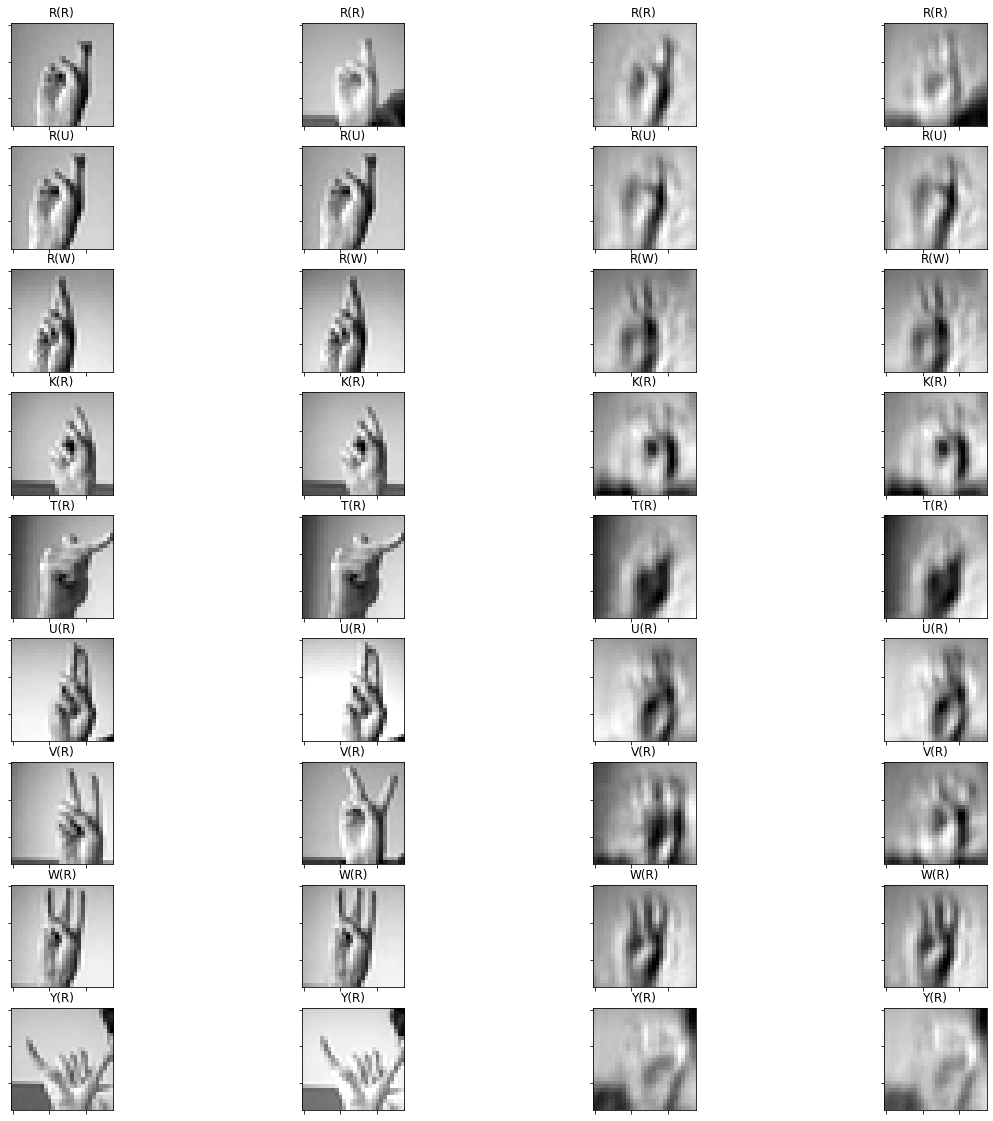

In [ ]:
plot_result_image(label_df)

<img src='./data/amer_sign2.png'>